In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_excel('data/M2.xlsx')

# Split the data into features (X) and target (y)
X = data.drop(columns=['WPR'])
y = data['WPR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (optional for Random Forest but recommended for consistency)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the shapes of the training and testing sets
print(X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape)


(7008, 7) (1752, 7) (7008,) (1752,)


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the Random Forest model structure
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, warm_start=True)

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_maes = []
val_maes = []

# Custom training loop
n_epochs = 5000
for epoch in range(1, n_epochs + 1):
    rf_model.n_estimators = epoch  # Increment the number of trees
    rf_model.fit(X_train_scaled, y_train)  # Fit the model

    # Predictions
    y_train_pred = rf_model.predict(X_train_scaled)
    y_val_pred = rf_model.predict(X_test_scaled)

    # Calculate loss and MAE
    train_loss = mean_squared_error(y_train, y_train_pred)
    val_loss = mean_squared_error(y_test, y_val_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_test, y_val_pred)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)

    # Print metrics for the epoch
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Train MAE = {train_mae:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val MAE = {val_mae:.4f}")


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import joblib

# Save the model
joblib.dump(rf_model, 'models/rf_model.joblib')


['models/rf_model.joblib']

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_scaled)
y_train_pred_rf = rf_model.predict(X_train_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'MSE: {mse_rf}, R²: {r2_rf}')


MSE: 557371.0124903198, R²: 0.8900388697072894


In [ ]:
# Export actual vs. predicted values to CSV and Excel files
results_rf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})
results_train_rf = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_rf})



# Save to Excel
results_rf.to_excel('results/actual_vs_predicted_test_rf.xlsx', index=False)
results_train_rf.to_excel('results/actual_vs_predicted_train_rf.xlsx', index=False)


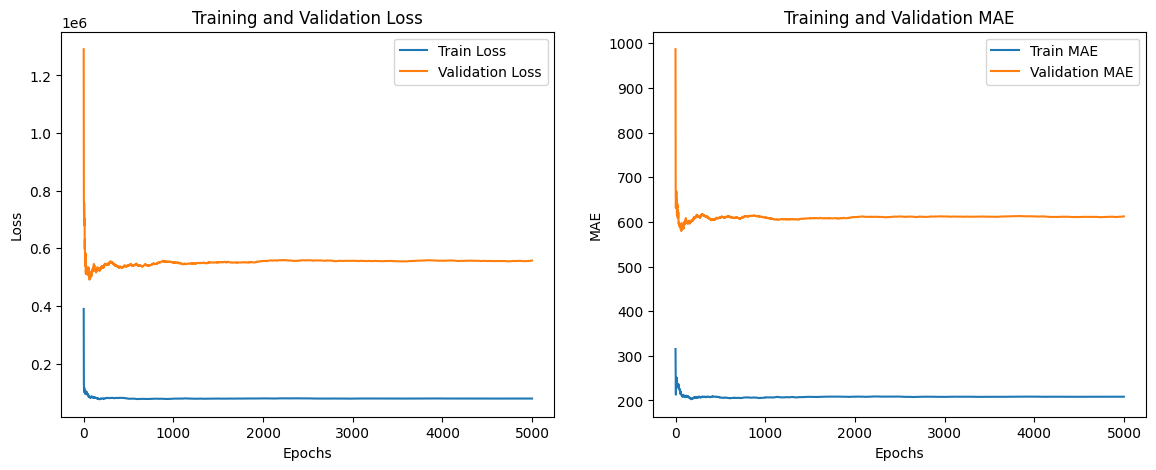

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Mean Absolute Error: {mae_rf}')


Mean Absolute Error: 612.3485359921241


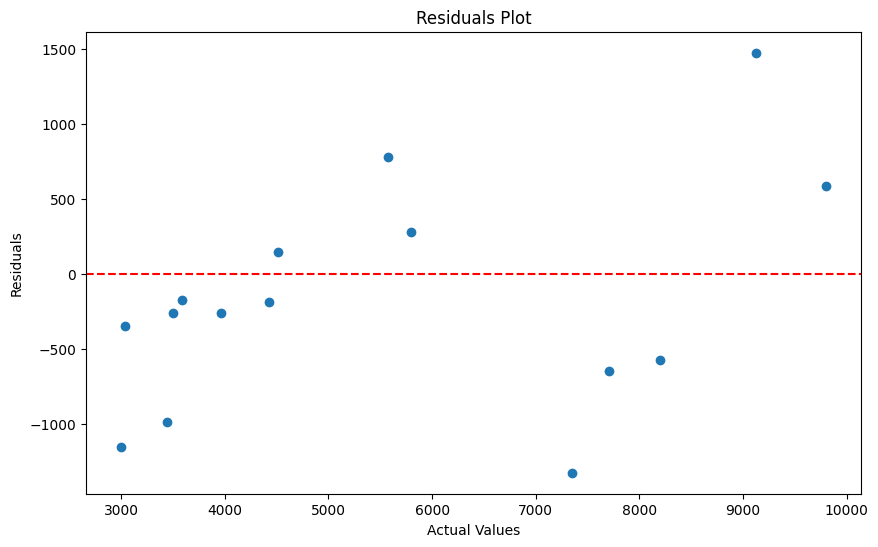

In [ ]:
# Plot residuals
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


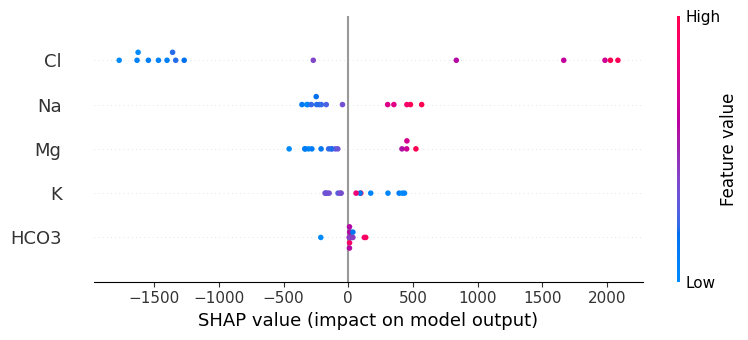

In [ ]:
import shap

# Explain the model predictions using SHAP
explainer_rf = shap.Explainer(rf_model)
shap_values_rf = explainer_rf(X_test_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns)
